In [22]:
import pandas as pd
from datasets import load_dataset, Dataset
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json

## Load Datasets

In [23]:
#!pip install --upgrade datasets fsspec

## **Dataset Evaluation**

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
hate_df = pd.read_csv("/content/drive/MyDrive/DS266/Project/Data/RawData/combined_hate_detect_raw.csv")
hate_df

,text,hatespeech,language,target,directness,annotator_sentiment,group
0,رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرض...,0.0,arabic,normal,normal,normal,normal
1,قال رسول الله ﷺ : . عليكَ بالرِّفقِ ؛ فإنَّهُ ...,0.0,arabic,normal,normal,normal,normal
2,و لا المانيا ولا بريطانيا و لا امريكا ولا روسي...,0.0,arabic,normal,normal,normal,normal
3,اي كذبه فيهم,0.0,arabic,normal,normal,normal,normal
4,شكرًا للناس اللي معانا بدون أسباب،بدون شروط،بد...,0.0,arabic,normal,normal,normal,normal
...,...,...,...,...,...,...,...
38499,@DOlusegun @elrufai Hope they don't becomes #D...,0.0,english,normal,normal,normal,normal
38500,@gtconway3d @KellyannePolls @realDonaldTrump H...,0.0,english,normal,normal,normal,normal
38501,@washingtonpost This is something everyone sho...,0.0,english,normal,normal,normal,normal
38502,Sorry about that. Has anybody got a #dickhead ...,0.0,english,normal,normal,normal,normal


array([[<Axes: title={'center': 'hatespeech'}>]], dtype=object)

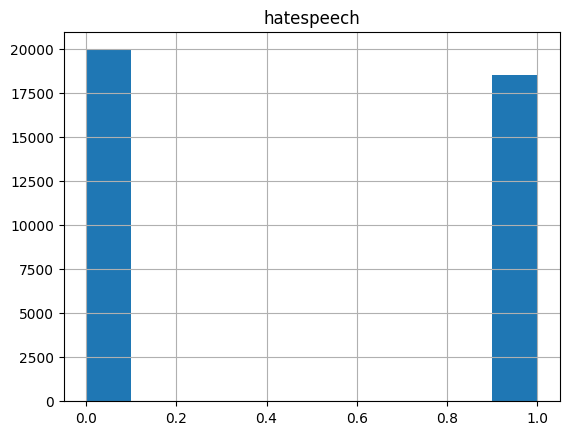

In [28]:
hate_df.hist('hatespeech')

In [29]:
hate_df['language'].value_counts()

,count
language,
english,21158
french,8993
arabic,8353


In [30]:
hate_df.groupby(['language', 'hatespeech']).size().unstack(fill_value=0)

hatespeech,0.0,1.0
language,,
arabic,5000,3353
english,10008,11150
french,4980,4013


## Encode Categorical Output Variables

In [31]:
label_maps = {}
for col in ['directness', 'target', 'group']:
    le = LabelEncoder()
    hate_df[col + '_label'] = le.fit_transform(hate_df[col].astype(str))
    # Convert keys to str for JSON compatibility
    label_maps[col] = {str(k): v for k, v in zip(le.transform(le.classes_), le.classes_)}

with open('../label_maps.json', 'w') as f:
    json.dump(label_maps, f)

In [32]:
# Split annotator_sentiment values by "_" and count distinct sentiments

# Drop NaN and split by '_', then flatten the list
all_sentiments = hate_df['annotator_sentiment'].apply(lambda x: x.split('_'))
# all_sentiments
flat_sentiments = [sent for sublist in all_sentiments for sent in sublist]
# flat_sentiments

# Get unique sentiments and their count
unique_sentiments = set(flat_sentiments)
print(f"Distinct annotator sentiments ({len(unique_sentiments)}): {unique_sentiments}")

Distinct annotator sentiments (8): {'indifference', 'fear', 'normal', 'shock', 'disgust', 'confusion', 'sadness', 'anger'}


In [33]:
# Get all unique sentiments
all_sentiments = sorted({s for x in hate_df['annotator_sentiment'].dropna() for s in x.split('_')})

# Multi-hot encode
for sentiment in all_sentiments:
    hate_df[f'sentiment_{sentiment}'] = hate_df['annotator_sentiment'].apply(
        lambda x: int(sentiment in x.split('_')) if isinstance(x, str) else 0
    )
# The columns sentiment_anger, sentiment_confusion, ... are the multi-label targets
print(hate_df.columns)
hate_df.head()

Index(['text', 'hatespeech', 'language', 'target', 'directness',
       'annotator_sentiment', 'group', 'directness_label', 'target_label',
       'group_label', 'sentiment_anger', 'sentiment_confusion',
       'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference',
       'sentiment_normal', 'sentiment_sadness', 'sentiment_shock'],
      dtype='object')


,text,hatespeech,language,target,directness,annotator_sentiment,group,directness_label,target_label,group_label,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock
0,رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرض...,0.0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0
1,قال رسول الله ﷺ : . عليكَ بالرِّفقِ ؛ فإنَّهُ ...,0.0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0
2,و لا المانيا ولا بريطانيا و لا امريكا ولا روسي...,0.0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0
3,اي كذبه فيهم,0.0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0
4,شكرًا للناس اللي معانا بدون أسباب،بدون شروط،بد...,0.0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0


## Clean Text

In [34]:
# Clean text for all datasets: combined_df, mlma_df, berkeley_df, ar_hf, fr_hf

def clean_text_column(df, text_col='text', new_col='text_cleaned'):
    unwanted_chars = (
        r'@URL', r'@url', r'@user', r'\\ude02', r'\\ud83d', r'\\u2026', r'\\u201c', r'\\u201d', r'\\udc4d', r'\\n', r'\\uffe3',
        r'\\ud83e', r'\\udd26', r'\\u2044', r'\\u25d5', r'\\udd26', r'\\u03c9', r'\\ud83c', r'\\udc80', r'\\udded', r'\\uddf7',
        r'\\u2022', r'\\u25e1', r'\\udffd', r'\\u200d', r'\\u2640', r'\\ude37', r'\\udc40', r'\\ude1f', r'\\udd37', r'\\u2642',
        r'\\ude2d', r'\\udd25', r'\\ude44', r'\\u2018', r'\\u2744', r'\\udff3', r'\\udf08', r'\\udc13', r'\\udd38', r'\\udc4a',
        r'\\ude12', r'\\uddfa', r'\\uddf2', r'\\uded1', r'\\u25b7', r'\\u25c1', r'\\u2665', r'\\uff46', r'\\uff41', r'\\uff45',
        r'\\uff54', r'\\udc47', r'\\udffb', r'\\ude05', r'\\udc4c', r'\\u270b', r'\\udeab', r'\\udfe2', r'\\uddf9', r'\\ude08',
        r'\\udc3e', r'\\ude03', r'\\udca3', r'\\ude0e', r'\\udd23', r'\\udd95', r'\\udf33', r'\\ude1a', r'\\udf8a', r'\\udd2a',
        r'\\u2800', r'\\u275b', r'&amp', r'&gt;', r'&lt;', r'URL'
    )
    df[new_col] = df[text_col].copy()
    df[new_col] = df[new_col].str.replace(r'\\u2019', "'", case=False, regex=True)
    for char in unwanted_chars:
        df[new_col] = df[new_col].str.replace(char, " ", case=False, regex=True)
    df[new_col] = df[new_col].apply(lambda x: re.sub(r'\s+', ' ', x.strip()) if isinstance(x, str) else x)
    return df

hate_df = clean_text_column(hate_df)
hate_df

,text,hatespeech,language,target,directness,annotator_sentiment,group,directness_label,target_label,group_label,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock,text_cleaned
0,رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرض...,0.0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,رُغم قُبلته الإعتذار لها ، لكنها ما زالت مُعرض...
1,قال رسول الله ﷺ : . عليكَ بالرِّفقِ ؛ فإنَّهُ ...,0.0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,قال رسول الله ﷺ : . عليكَ بالرِّفقِ ؛ فإنَّهُ ...
2,و لا المانيا ولا بريطانيا و لا امريكا ولا روسي...,0.0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,و لا المانيا ولا بريطانيا و لا امريكا ولا روسي...
3,اي كذبه فيهم,0.0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,اي كذبه فيهم
4,شكرًا للناس اللي معانا بدون أسباب،بدون شروط،بد...,0.0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,شكرًا للناس اللي معانا بدون أسباب،بدون شروط،بد...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38499,@DOlusegun @elrufai Hope they don't becomes #D...,0.0,english,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,@DOlusegun @elrufai Hope they don't becomes #D...
38500,@gtconway3d @KellyannePolls @realDonaldTrump H...,0.0,english,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,@gtconway3d @KellyannePolls @realDonaldTrump H...
38501,@washingtonpost This is something everyone sho...,0.0,english,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,@washingtonpost This is something everyone sho...
38502,Sorry about that. Has anybody got a #dickhead ...,0.0,english,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,Sorry about that. Has anybody got a #dickhead ...


In [35]:
# remove @USER from all rows
hate_df.loc[:, 'text'] = hate_df['text'].str.replace(r'@USER', '', regex=True).str.strip().str.replace(r'\s+', ' ', regex=True)

## Visualizations

### Text Length Distributions

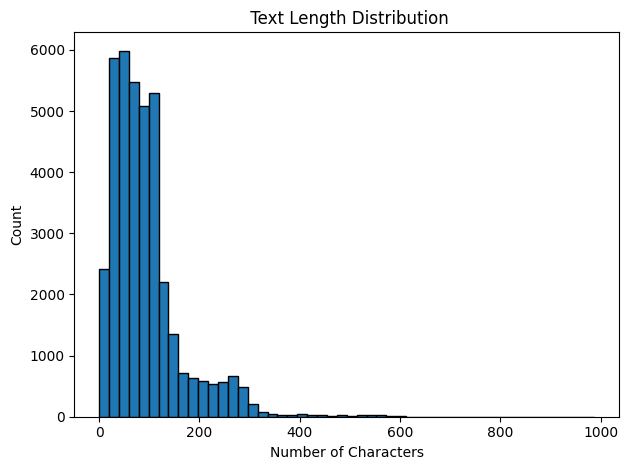

In [36]:
datasets = [
    ("Combined Dataset", hate_df),
]


hate_df['text_length'] = hate_df['text_cleaned'].astype(str).apply(len)
counts, bins, patches = plt.hist(hate_df['text_length'], bins=50, edgecolor='black')
plt.title(f" Text Length Distribution")
plt.ylabel('Count')

#plt.text((bin_left + bin_right) / 2, count, str(int(count)),ha='center', va='bottom', fontsize=7, rotation=45)
plt.xlabel('Number of Characters')
plt.tight_layout()
plt.show()

In [37]:
hate_df['language'].value_counts()

,count
language,
english,21158
french,8993
arabic,8353


In [38]:
hate_df.groupby(['language', 'hatespeech']).size().unstack(fill_value=0)

hatespeech,0.0,1.0
language,,
arabic,5000,3353
english,10008,11150
french,4980,4013


array([[<Axes: title={'center': 'hatespeech'}>]], dtype=object)

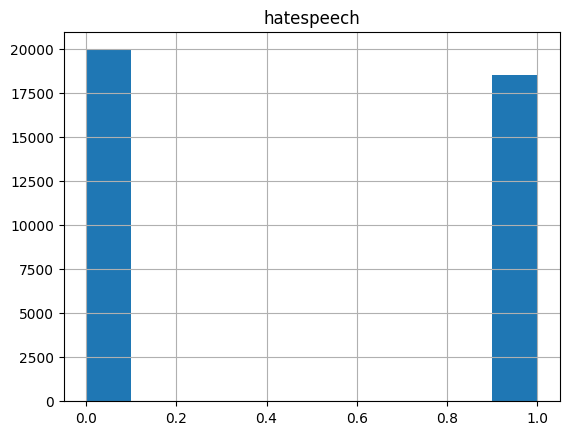

In [39]:
hate_df.hist('hatespeech')

# Shuffle

In [40]:
shuffled_df = hate_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [41]:
shuffled_df

,text,hatespeech,language,target,directness,annotator_sentiment,group,directness_label,target_label,group_label,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock,text_cleaned,text_length
0,يلعن شرفك يا حكم!!!,0.0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,يلعن شرفك يا حكم!!!,19
1,imagine yoongi working tongue technology hands...,1.0,english,other,indirect,anger_sadness_shock_indifference_disgust,other,1,4,13,1,0,1,0,1,0,1,1,imagine yoongi working tongue technology hands...,83
2,RT @J23app: Feb 2015 Jordan 4 Retro Remastered...,0.0,english,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,RT @J23app: Feb 2015 Jordan 4 Retro Remastered...,87
3,"Le #sexiste, anti #IVG #Avortement, #Libertici...",0.0,french,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,"Le #sexiste, anti #IVG #Avortement, #Libertici...",89
4,Blague : Mec : Je vais me laisser pousser la m...,0.0,french,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,Blague : Mec : Je vais me laisser pousser la m...,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38499,bande d'islamo gaucho,0.0,french,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,bande d'islamo gaucho,21
38500,و إن قالوا جنون انا رافض افوووق,1.0,arabic,other,indirect,indifference,individual,1,4,8,0,0,0,0,1,0,0,0,و إن قالوا جنون انا رافض افوووق,31
38501,"Dean is a muppet, don’t be like Dean #DickHead...",0.0,english,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,"Dean is a muppet, don’t be like Dean #DickHead...",70
38502,من عدم الحاجة إلى تشغيل أكثر من حساب يتسبب في ...,0.0,arabic,normal,normal,normal,normal,2,2,12,0,0,0,0,0,1,0,0,من عدم الحاجة إلى تشغيل أكثر من حساب يتسبب في ...,242


In [42]:
shuffled_df.to_csv("/content/drive/MyDrive/DS266/Project/Data/combined_hate_detect_cleaned.csv", index=False)

## Split, and Export Datasets

In [43]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np

def iterative_split_and_export(df, prefix):
    # Identify feature and label columns
    label_cols = [col for col in df.columns if col.startswith('sentiment_') or
                  col in ['language_encoded', 'directness_label', 'target_label', 'group_label', 'hatespeech']]
    feature_cols = [col for col in df.columns if col not in label_cols]

    # Convert to numpy arrays
    X = df[feature_cols].values
    y = df[label_cols].values.astype(int)

    # First split: train (80%), temp (20%)
    X_train, y_train, X_temp, y_temp = iterative_train_test_split(X, y, test_size=0.2)
    # Second split: val (10%), test (10%) from temp
    X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)

    # Convert back to DataFrames
    train_df = pd.DataFrame(np.hstack([X_train, y_train]), columns=feature_cols + label_cols)
    val_df = pd.DataFrame(np.hstack([X_val, y_val]), columns=feature_cols + label_cols)
    test_df = pd.DataFrame(np.hstack([X_test, y_test]), columns=feature_cols + label_cols)

    # Ensure correct dtypes for integer columns
    for col in label_cols + ['directness_label', 'target_label', 'group_label', 'hatespeech']:
        if col in train_df.columns:
            train_df[col] = train_df[col].astype(int)
            val_df[col] = val_df[col].astype(int)
            test_df[col] = test_df[col].astype(int)

    # Filter wanted columns
    cols_to_keep = [
        'text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech'
    ] + label_cols
    train_export = train_df[cols_to_keep]
    val_export = val_df[cols_to_keep]
    test_export = test_df[cols_to_keep]

    # Output to CSV
    train_export.to_csv(f"/content/drive/MyDrive/DS266/Project/Data/{prefix}_train.csv", index=False)
    val_export.to_csv(f"/content/drive/MyDrive/DS266/Project/Data/{prefix}_val.csv", index=False)
    test_export.to_csv(f"/content/drive/MyDrive/DS266/Project/Data/{prefix}_test.csv", index=False)

    print(f"{prefix.capitalize()} Train size: {train_export.shape}")
    print(f"{prefix.capitalize()} Validation size: {val_export.shape}")
    print(f"{prefix.capitalize()} Test size: {test_export.shape}")
    return train_export.head()

# For combined_df
shuffled_df["language_encoded"] = shuffled_df["language"].map({"english": 0, "french": 1, "arabic": 2})
iterative_split_and_export(shuffled_df, "combined")

Combined Train size: (30702, 19)
Combined Validation size: (3901, 19)
Combined Test size: (3901, 19)


,text_cleaned,language,directness_label,target_label,group_label,hatespeech,hatespeech,directness_label,target_label,group_label,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock,language_encoded
0,يلعن شرفك يا حكم!!!,arabic,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,2
1,RT @J23app: Feb 2015 Jordan 4 Retro Remastered...,english,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,0
2,Blague : Mec : Je vais me laisser pousser la m...,french,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,1
3,I just put down a pan of brownies,english,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,0
4,في بني آدم عنده عقل بنزل مادة مقدمة في علم الم...,arabic,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,2


In [44]:
# Action items
# shuffle dataset
# ask mark on friday if we should truncate, keep long text or remove completely
# mbert : bella, XLMroberta- base : nadaa , roberta-large
# write the paper